<a href="https://colab.research.google.com/github/IbrahimTGhanem/Datathon4/blob/main/Dathathon_04_Group_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Section 1: Introduction**

"The accurate prediction of mortality in the first 24 hours following admission to an Intensive Care Unit (ICU) is of paramount importance in clinical medicine. Early and precise mortality risk assessment allows for effective resource allocation, ensuring that critical medical equipment and skilled personnel are available for the patients who need them the most. Additionally, it aids in strategic planning, allowing medical teams to prioritize interventions, tailor treatment plans, and make informed decisions about the potential benefits of aggressive versus palliative care strategies. Furthermore, early mortality predictions provide invaluable information to families, facilitating difficult conversations and helping loved ones set realistic expectations, prepare for potential outcomes, and make time-sensitive decisions about end-of-life care. In an environment where every moment counts, leveraging data from the first 24 hours of ICU admission for mortality prediction not only optimizes clinical interventions but also provides compassionate guidance to families during their most challenging times. Recognizing this, this datathon aims to explore the power of Machine Learning models to predict mortality using real-world data from that critical first day in the ICU, all with the goal of enhancing patient care and supporting families in their tough moments.

This dataset is provided in collaboration with MIT’s GOSSIS community initiative and has received privacy certification from the Harvard Privacy Lab. It includes records from over 91,000 intensive care unit (ICU) visits at various hospitals, covering an entire year. What makes this dataset truly unique is its global scope, as it is part of a collaborative effort connecting healthcare institutions in Argentina, Australia, New Zealand, Sri Lanka, Brazil, and over 200 hospitals in the United States".

**1.1: Importing Libraries and exploring data**

In [167]:
pip install category-encoders

In [168]:
# !pip install category_encoders

import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

In [169]:
#additional libraries on the go, as analysis require
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso
import statsmodels.api as sm

In [4]:
from google.colab import files

# Specify the path to the file on local machine
uploaded = files.upload()

Saving datathon4.csv to datathon4.csv


In [170]:
data = pd.read_csv('datathon4.csv')
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


**1.2: Process of omitting columns (ensuring high data quality)**

It is important examine variables and identify/drop irrlelavnt columns (i.e. identifiers/administrative data) and variables with a single value or with signigicant level of missing values. The threshold for that will be set at 20% based on findings from literature:
Peng CYJ, Harwell M, Liou SM, Ehman LH. Advances in missing data methods and implications for educational research. In: Sawilowsky SS, editor. Real data analysis. Charlotte, North Carolina: Information Age Pub; 2006. pp. 31–78.

In [9]:
#Dropping identifiers
identifiers_to_drop = ['encounter_id', 'hospital_id', 'patient_id', 'icu_id']
data = data.drop(columns=identifiers_to_drop)

In [10]:
#dropping administrative columns
admins_to_drop = ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
data = data.drop(columns=admins_to_drop)

single-value columns will not add value to any prediction models. In fact, it might represent noise in models

In [240]:
# Creating an empty list to store the names of columns with a single value
single_value_columns = []

# Iterating through the columns
for column in data.columns:
    if data[column].nunique() == 1:
        single_value_columns.append(column)

# Printing the list of columns with a single value
print("Columns with a single value for all observations:")
print(single_value_columns)

Columns with a single value for all observations:
['readmission_status']


In [241]:
#dropping single values columns as they may impact the analysis
data = data.drop(columns=single_value_columns)

Also, after examining variables closely it appears that over the column of pre_icu_los_days has around 750 of negative values. This variable represents the length of stay of a patient between hospital admission and unit admission. Yet, having negative values indicates a data quality aspect. Thus, this variable will be removed from anlaysis

In [11]:
low_quality_variable = ['pre_icu_los_days']
data = data.drop(columns=low_quality_variable)

In [12]:
#Describing data after omitting variables
description = data.describe()
description

,hospital_death,age,bmi,elective_surgery,height,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.0,88993.000000,37334.000000,90051.000000,90612.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,0.086302,62.309516,29.185818,0.183736,169.641588,0.0,84.028340,2.902968,185.401739,558.216377,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,0.280811,16.775119,8.275142,0.387271,10.795378,0.0,25.011497,0.681863,86.050882,463.266985,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,0.000000,16.000000,14.844926,0.000000,137.200000,0.0,38.600000,1.200000,101.000000,0.010000,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.000000,23.641975,0.000000,162.500000,0.0,66.800000,2.400000,113.000000,203.010000,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,27.654655,0.000000,170.100000,0.0,80.300000,2.900000,122.000000,409.020000,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,75.000000,32.930206,0.000000,177.800000,0.0,97.100000,3.400000,301.000000,703.030000,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,89.000000,67.814990,1.000000,195.590000,0.0,186.000000,4.600000,308.000000,2201.050000,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Section 2: Data Engineering Process**

**2.1: Visualizng distribution of missing values and omitting variables with missing values that is above 20%**

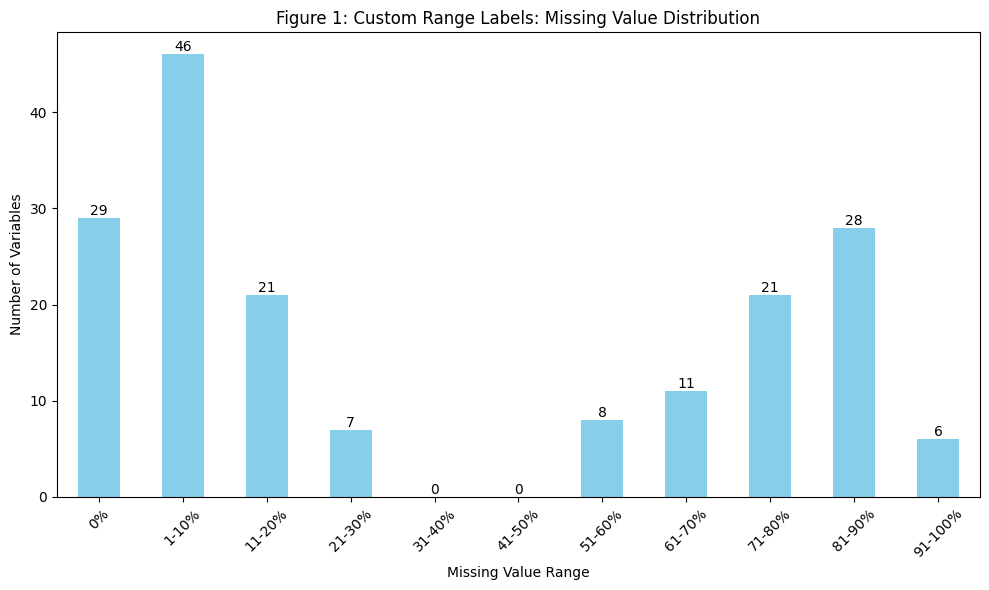

In [13]:
# Calculating the percentage of missing values in each column
missing_percentage = (data.isnull().mean() * 100)

# Defining custom range for bars
custom_labels = ['0%', '1-10%', '11-20%', '21-30%', '31-40%', '41-50%', '51-60%', '61-70%', '71-80%', '81-90%', '91-100%']

# Defining the range thresholds for bars
ranges = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Creating a dictionary to count variables in each range
range_counts = {custom_labels[i]: ((missing_percentage >= start) & (missing_percentage < end)).sum() for i, (start, end) in enumerate(zip(ranges, ranges[1:]))}

# Converting the dictionary to a DataFrame for plotting
range_counts_df = pd.DataFrame.from_dict(range_counts, orient='index', columns=['Count'])

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = range_counts_df.plot(kind='bar', ax=plt.gca(), color='skyblue', legend=False)
plt.xlabel("Missing Value Range")
plt.ylabel("Number of Variables")
plt.title("Figure 1: Custom Range Labels: Missing Value Distribution")
plt.xticks(rotation=45)

# Adding count labels to the bars
for i, v in enumerate(range_counts_df['Count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# Setting the threshold for the percentage of missing values
missing_threshold = 20  # 20% or more missing values

# Filtering columns with missing values exceeding the threshold
columns_with_high_missing = missing_percentage[missing_percentage > missing_threshold]

# Listing the columns with more than 20% missing values
print("Columns with more than 20% missing values:")
print(columns_with_high_missing.index.tolist())

Columns with more than 20% missing values:
['albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'hematocrit_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'sodium_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobi

In [15]:
count_of_high_missing_columns = len(columns_with_high_missing)
print("Count of columns with more than 20% missing values:", count_of_high_missing_columns)

Count of columns with more than 20% missing values: 81


In [16]:
#dropping variables with significant level of missing values
High_missing_values_to_drop = ['albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'hematocrit_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'sodium_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']
data = data.drop(columns=High_missing_values_to_drop)

In [17]:
# Checking for missing values
missing_value_counts = data.isnull().sum()
missing_value_counts

hospital_death                    0
age                            4228
bmi                            3429
elective_surgery                  0
ethnicity                      1395
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 96, dtype: int64

In [18]:
# Printing the dimension of the dataset
print(data.shape)

(91713, 96)


In [19]:
variables_list = data.columns.tolist()

# Printing the list of variables
print("List of Variables:")
for variable in variables_list:
    print(variable)

List of Variables:
hospital_death
age
bmi
elective_surgery
ethnicity
gender
height
readmission_status
weight
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
glucose_apache
heart_rate_apache
intubated_apache
map_apache
resprate_apache
temp_apache
ventilated_apache
d1_diasbp_max
d1_diasbp_min
d1_diasbp_noninvasive_max
d1_diasbp_noninvasive_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_mbp_noninvasive_max
d1_mbp_noninvasive_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_sysbp_noninvasive_max
d1_sysbp_noninvasive_min
d1_temp_max
d1_temp_min
h1_diasbp_max
h1_diasbp_min
h1_diasbp_noninvasive_max
h1_diasbp_noninvasive_min
h1_heartrate_max
h1_heartrate_min
h1_mbp_max
h1_mbp_min
h1_mbp_noninvasive_max
h1_mbp_noninvasive_min
h1_resprate_max
h1_resprate_min
h1_spo2_max
h1_spo2_min
h1_sysbp_max
h1_sysbp_min
h1_sysbp_noninvasive_max
h1_sysbp_noninva

**2.2 Examining the association between hospital death event and missing values in categorical, integer, and binary variables.**

Types of variables was obtained from the data dictionary sheet

In [20]:
# Listing of categorical variables
categorical_variables = ['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity', 'gender']

# Binary label variable
binary_label = 'hospital_death'

# Creating a function to apply a chi-squared test and check for association
def chi_squared_test(data, categorical_variable, binary_label):
    contingency_table = pd.crosstab(data[categorical_variable].isnull(), data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying a chi-squared tests for each categorical variable
for variable in categorical_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for apache_3j_bodysystem:
  - P-value: 0.5410461111346306
  - There is no significant association between missing values and hospital death.


Chi-squared test for apache_2_bodysystem:
  - P-value: 0.5410461111346306
  - There is no significant association between missing values and hospital death.


Chi-squared test for ethnicity:
  - P-value: 0.15250983852914854
  - There is no significant association between missing values and hospital death.


Chi-squared test for gender:
  - P-value: 0.0001414835016997219
  - There is a significant association between missing values and hospital death.




With regard to gender, the signficance here can be ignored as missing observations are only 25

In [21]:
# Listing of binary variables
binary_variables = [
    "elective_surgery",
    "apache_post_operative",
    "arf_apache",
    "gcs_unable_apache",
    "intubated_apache",
    "ventilated_apache",
    "aids",
    "cirrhosis",
    "diabetes_mellitus",
    "hepatic_failure",
    "immunosuppression",
    "leukemia",
    "lymphoma",
    "solid_tumor_with_metastasis"
]

# Binary label variable
binary_label = 'hospital_death'

# Creating a function to perform a chi-squared test and check for association
def chi_squared_test(data, binary_variable, binary_label):
    contingency_table = pd.crosstab(data[binary_variable] == 'NA', data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying chi-squared tests for each binary variable
for variable in binary_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for elective_surgery:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for apache_post_operative:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for arf_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for gcs_unable_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for intubated_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for ventilated_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for aids:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for cir

In [22]:
ordinal_variables = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Creating a function to apply a chi-squared test and check for association
def chi_squared_test(data, integer_variable, binary_label):
    contingency_table = pd.crosstab(data[integer_variable].astype(str) == 'NA', data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying chi-squared tests for each integer variable
for variable in ordinal_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for gcs_eyes_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for gcs_motor_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for gcs_verbal_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.




In [23]:
integer_variables = ['apache_2_diagnosis', 'apache_3j_diagnosis',]

# Creating a function to perform a chi-squared test and check for association
def chi_squared_test(data, integer_variable, binary_label):
    contingency_table = pd.crosstab(data[integer_variable].astype(str) == 'NA', data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Performing chi-squared tests for each integer variable
for variable in integer_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for apache_2_diagnosis:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for apache_3j_diagnosis:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.




In [24]:
# Listing of numeric variables
numeric_variables = [
    "age",
    "bmi",
    "height",
    "weight",
    "glucose_apache",
    "heart_rate_apache",
    "map_apache",
    "resprate_apache",
    "temp_apache",
    "d1_diasbp_max",
    "d1_diasbp_min",
    "d1_diasbp_noninvasive_max",
    "d1_diasbp_noninvasive_min",
    "d1_heartrate_max",
    "d1_heartrate_min",
    "d1_mbp_max",
    "d1_mbp_min",
    "d1_mbp_noninvasive_max",
    "d1_mbp_noninvasive_min",
    "d1_resprate_max",
    "d1_resprate_min",
    "d1_spo2_max",
    "d1_spo2_min",
    "d1_sysbp_max",
    "d1_sysbp_min",
    "d1_sysbp_noninvasive_max",
    "d1_sysbp_noninvasive_min",
    "d1_temp_max",
    "d1_temp_min",
    "h1_diasbp_max",
    "h1_diasbp_min",
    "h1_diasbp_noninvasive_max",
    "h1_diasbp_noninvasive_min",
    "h1_heartrate_max",
    "h1_heartrate_min",
    "h1_mbp_max",
    "h1_mbp_min",
    "h1_mbp_noninvasive_max",
    "h1_mbp_noninvasive_min",
    "h1_resprate_max",
    "h1_resprate_min",
    "h1_spo2_max",
    "h1_spo2_min",
    "h1_sysbp_max",
    "h1_sysbp_min",
    "h1_sysbp_noninvasive_max",
    "h1_sysbp_noninvasive_min",
    "d1_bun_max",
    "d1_bun_min",
    "d1_calcium_max",
    "d1_calcium_min",
    "d1_creatinine_max",
    "d1_creatinine_min",
    "d1_glucose_max",
    "d1_glucose_min",
    "d1_hco3_max",
    "d1_hco3_min",
    "d1_hemaglobin_max",
    "d1_hemaglobin_min",
    "d1_hematocrit_max",
    "d1_hematocrit_min",
    "d1_platelets_max",
    "d1_platelets_min",
    "d1_potassium_max",
    "d1_potassium_min",
    "d1_sodium_max",
    "d1_sodium_min",
    "d1_wbc_max",
    "d1_wbc_min",
    "apache_4a_hospital_death_prob",
    "apache_4a_icu_death_prob"
]

Based on the application of the previous statistical test, there is no signifcant association between missing observations and the dependent variables. Thus, it is evident that that these mmissing value amy be missing completely at random (MCAR) or at least missing at random (MAR). Thus, it is possible to apply imputation strategies

**2.3: checking potential class imbalance**

In [27]:
data['Hospital Death'] = np.where(data['hospital_death'] == 1, 'Passed Away', 'Did Not Pass Away')

In [28]:
counts = data['Hospital Death'].value_counts()

# Define color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in "Hospital Death"',
    color_discrete_sequence=colors  # apply colors here
)

# layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Hospital Death'
    ),
    title=dict(
        text='Figure 2: Distribution of Classes in "Hospital Death"',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

While there are no missing values in the label class, there is a clear class imbalance in the label/target variable where only 8.6% of the observations belong to the category of 'Passed away'. This issue entails the need for either upsampling or downsampling, which will be tackled before running classification models.

**2.4 Vizualizing variables, and tackling outliers**

In [29]:
data = data.replace('NA', np.nan)
data[categorical_variables] = data[categorical_variables].replace('', np.nan)

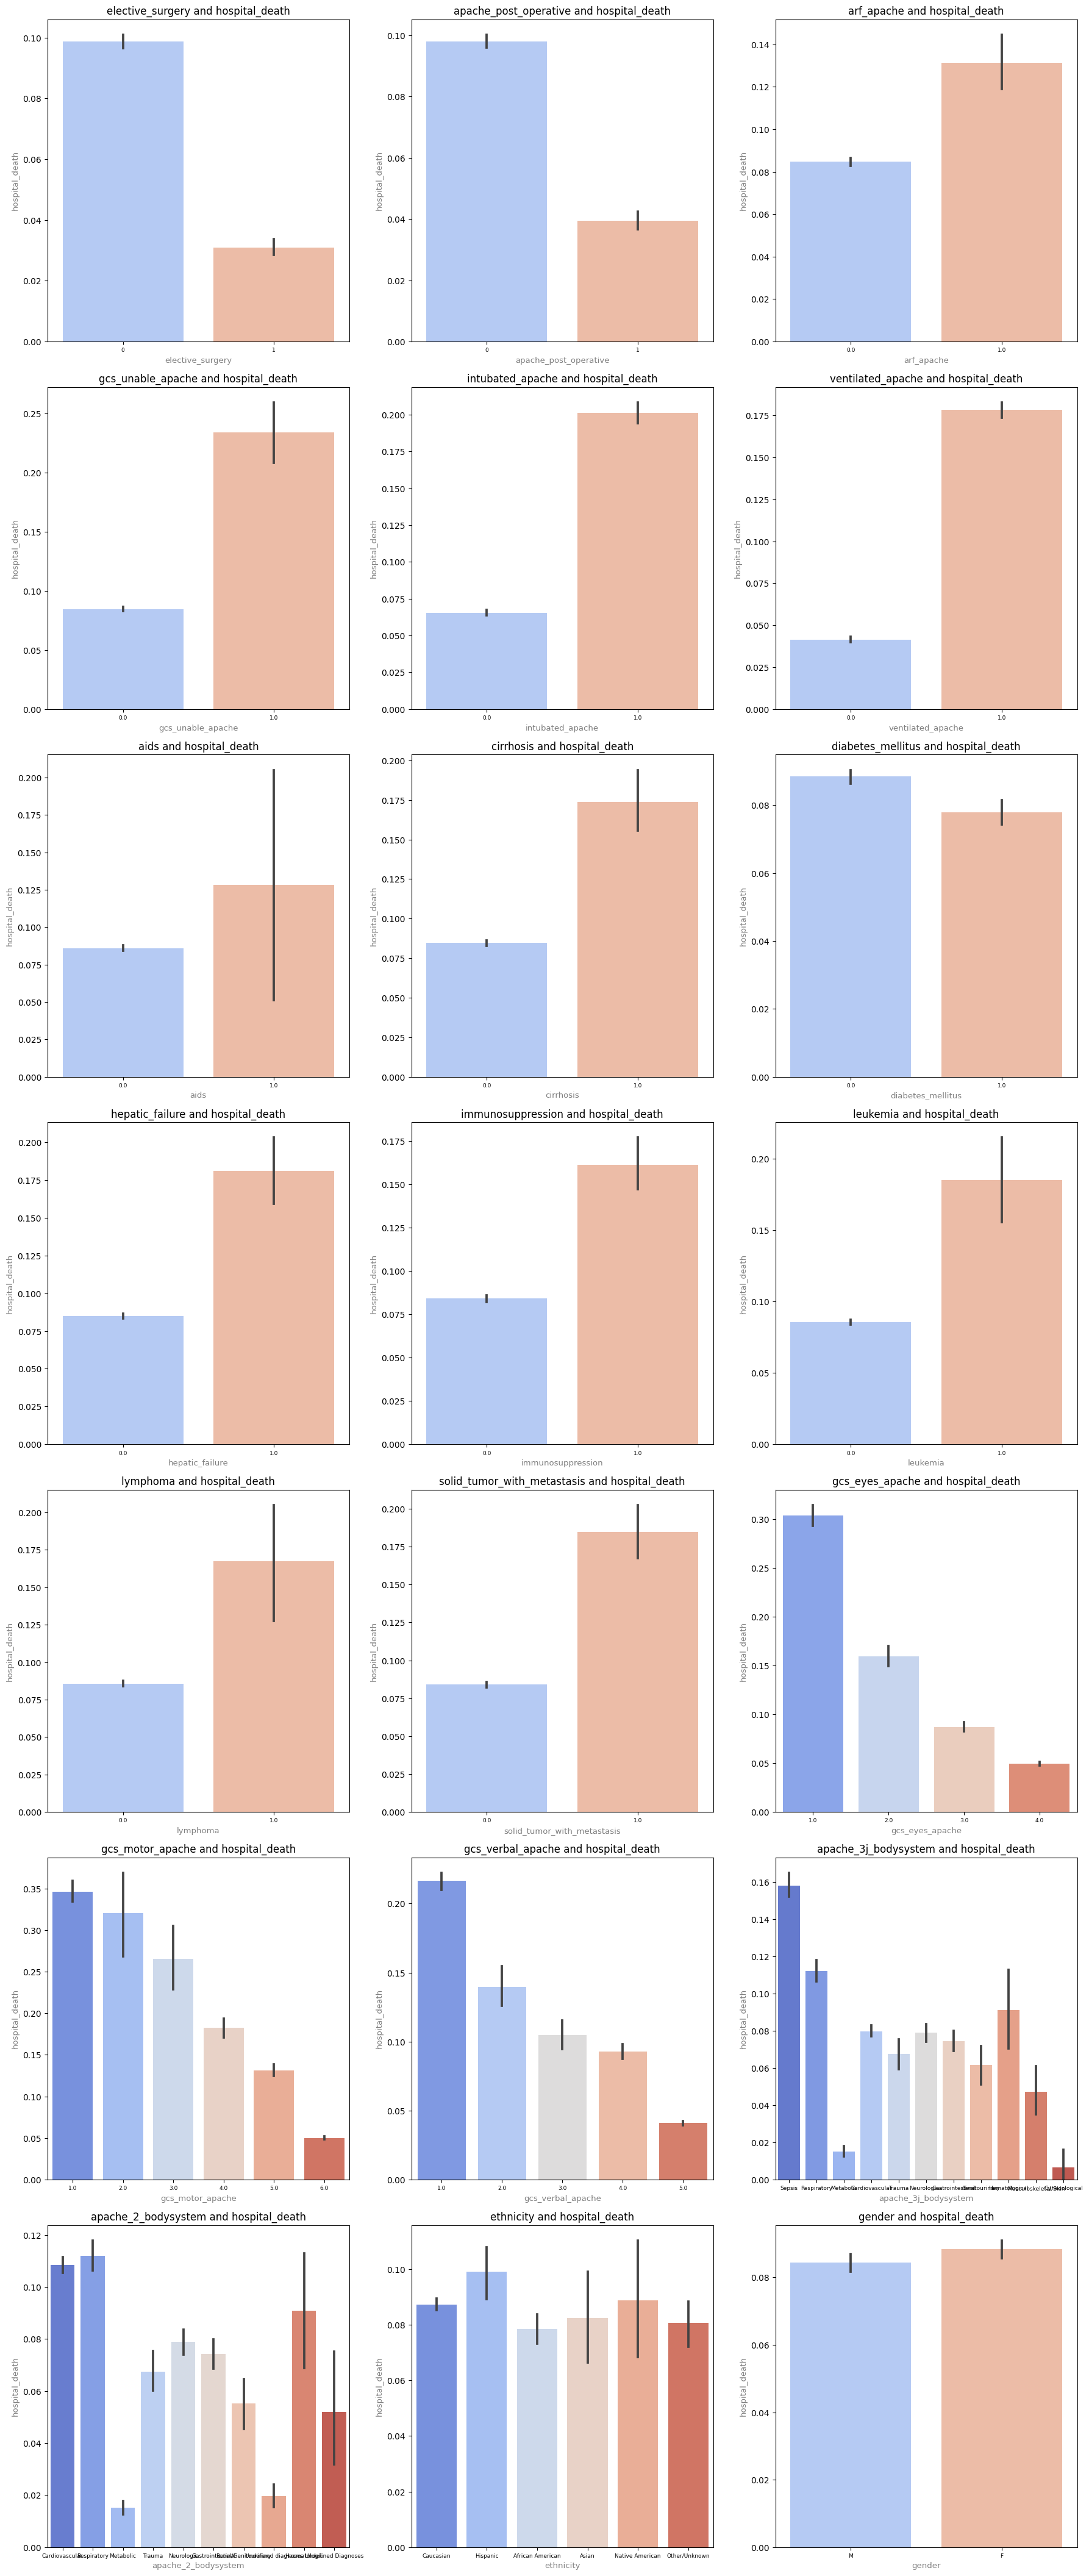

In [30]:
# Grouping variables into binary, ordinal, and categorical
binary_ordinal_categorical = binary_variables + ordinal_variables + categorical_variables

#Setting Y/class

Class= 'hospital_death'

# Determining the number of subplots in each row
subplots_per_row = 3
total_rows = len(binary_ordinal_categorical) // subplots_per_row + 1

# Creating bar plots
fig, axes = plt.subplots(total_rows, subplots_per_row, figsize=(18, 6 * total_rows))

for i, variable_name in enumerate(binary_ordinal_categorical):
    row = i // subplots_per_row
    col = i % subplots_per_row
    sns.barplot(data=data, x=variable_name, y=Class, palette='coolwarm', ax=axes[row, col])
    axes[row, col].set_title(f"{variable_name} and {Class}")

# Adjusting the font size for unit names
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), fontsize=6.5)

# Adding and adjusting lables for both axes
for row in axes:
    for ax in row:
        ax.set_xlabel(ax.get_xlabel(), color='grey', fontsize=9.5)
        ax.set_ylabel(ax.get_ylabel(), color='grey', fontsize=9.5)

# Removing  empty subplots
for i in range(len(binary_ordinal_categorical), total_rows * subplots_per_row):
    fig.delaxes(axes[i // subplots_per_row, i % subplots_per_row])

plt.tight_layout()
plt.show()

It appears that gdifferences in gender and ethnicity have limited significant association with the label class. Thus these two variables will be removed from analysis

In [31]:
Deleting_categorical = ['gender', 'ethnicity']
data = data.drop(columns= Deleting_categorical)

In [37]:
categorical_variables

['apache_3j_bodysystem', 'apache_2_bodysystem']

In [36]:
categorical_variables.remove('gender')
categorical_variables.remove('ethnicity')

In [38]:
# Initialize the StandardScaler
scaler = StandardScaler()

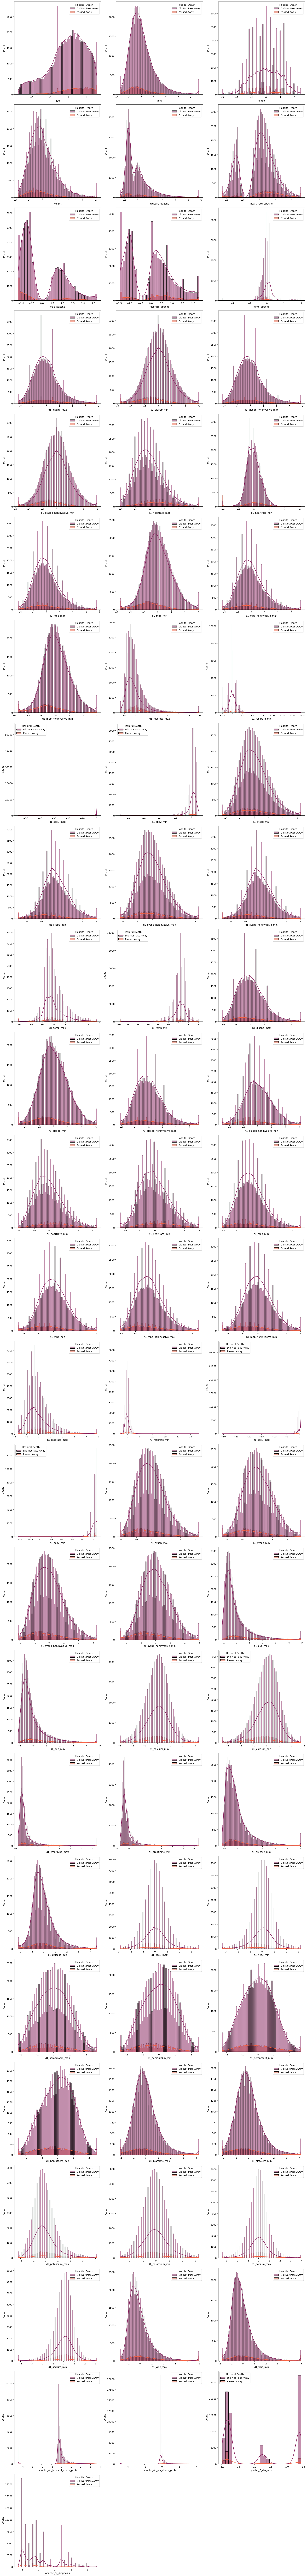

In [39]:
# Grouping variables into numeric and integer
numeric_integer = numeric_variables + integer_variables

# Determining the number of subplots in each row
subplots_per_row = 3
total_rows = len(numeric_integer) // subplots_per_row + 1

# Creating a grid of subplots
fig, axs = plt.subplots(total_rows, subplots_per_row, figsize=(18, 6 * total_rows))

# Creating a copy of the original data
data_copy = data.copy()

# Looping through each feature in numeric_integer
for i, column in enumerate(numeric_integer):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // subplots_per_row
    y = i % subplots_per_row

    # Scaling the feature in the copied data using StandardScaler
    data_copy[column] = scaler.fit_transform(data_copy[[column]])

    # Plot a histogram of the scaled feature split by the 'hospital_death' class
    sns.histplot(data=data_copy, x=column, hue='Hospital Death', kde=True, palette='rocket', ax=axs[x][y])

# Removing any empty subplots
for i in range(len(numeric_integer), total_rows * subplots_per_row):
    fig.delaxes(axs[i // subplots_per_row, i % subplots_per_row])

# Display all the subplots
plt.tight_layout()
plt.show()


Histograms with Kernerl Density Estimation (KDE) were used to examine the association between the class variable and the scaled numeric/integer variables. It appears that there are many variables where the distributions of the two classes vary singicantly. Yet most importantly, it appears that also many vairables have extreme outliers. This is understandable as many cases that will arrive at ICU will have extreme medical conditions.

In [40]:
#Removing visualization variable
Data = data.drop(columns=['Hospital Death'])

**2.5 Splitting data, Imputing  missing observations, and Specifying data categories**

In [46]:
X = data.drop('hospital_death', axis=1)
y = data['hospital_death']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data imputation is carried out after splitting data to avoid data leakage from train to test data. Simple imputation strategies will be applied as they are straightforward and require less configuration. Yet, they are less sensitive the distribution of the data compared to iterive imputing strategy.

In [47]:
# Creating an imputer for numeric variables with the strategy of 'mean'
numeric_imputer = SimpleImputer(strategy='mean')

# Imputing numeric variables in the training set
X_train[numeric_variables] = numeric_imputer.fit_transform(X_train[numeric_variables])

# Imputing numeric variables in the test set
X_test[numeric_variables] = numeric_imputer.transform(X_test[numeric_variables])

In [48]:
#Creating an imputer for intefer variables with the straegy of 'median'
integer_imputer = SimpleImputer(strategy='median')

# Imputing integer variables in the training set
X_train[integer_variables] = integer_imputer.fit_transform(X_train[integer_variables])

# Imputing integer variables in the test set
X_test[integer_variables] = integer_imputer.transform(X_test[integer_variables])

In [49]:
# Creating an imputer for categorical, ordinal, and binary variables with the strategy of 'most_frequent/mode'
category_imputer = SimpleImputer(strategy='most_frequent')

# Imputing categorical, ordinal, and binary variables in the training set
X_train[categorical_variables + ordinal_variables + binary_variables] = category_imputer.fit_transform(X_train[categorical_variables + ordinal_variables + binary_variables])

# Imputing categorical, ordinal, and binary variables in the test set
X_test[categorical_variables + ordinal_variables + binary_variables] = category_imputer.transform(X_test[categorical_variables + ordinal_variables + binary_variables])


In [45]:
print("Numeric Variables:")
print(numeric_variables)
print("Count of Numeric Variables:", len(numeric_variables))

Numeric Variables:
['age', 'bmi', 'height', 'weight', 'glucose_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_crea

In [50]:
# Specifying data types for the training set
X_train[numeric_variables] = X_train[numeric_variables].astype(float)
X_train[integer_variables] = X_train[integer_variables].astype(int)
X_train[categorical_variables] = X_train[categorical_variables].astype('category')
X_train[binary_variables] = X_train[binary_variables].astype(int)
X_train[ordinal_variables] = X_train[ordinal_variables].astype(int)
y_train = y_train.astype(int)

# Specify data types for the test set
X_test[numeric_variables] = X_test[numeric_variables].astype(float)
X_test[integer_variables] = X_test[integer_variables].astype(int)
X_test[categorical_variables] = X_test[categorical_variables].astype('category')
X_test[binary_variables] = X_test[binary_variables].astype(int)
X_test[ordinal_variables] = X_test[ordinal_variables].astype(int)
y_test = y_test.astype(int)


**Back to tackling imbalanced data.**

Highly imbalanced dataset (i.e., one class is predominant), might lead to the situation where a predictive model might not able to make meaningful distinctions between the classes. As the majoirty class (patients who did not pass away) are signifcantly larger than the minority class, undersampling will be used to balance the classes. In fact, this method will be computationally effecient as  it will reduce the observations in our large datasets. Yet, we might still risk losing infomration due to omitting observations for the majority classes.

In [52]:
# Application of RUS for undersampling  the training data
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Specifying categorical and ordinal columns to one-hot encode
categorical_ordinal_columns = categorical_variables + ordinal_variables

# Initializing a column transformer for one-hot encoding
ct = ColumnTransformer(
    transformers=[('one_hot_encoder', OneHotEncoder(), categorical_ordinal_columns)],
    remainder='passthrough'
)

# Applying the one-hot encoding transformation to X_resampled and X_test
X_resampled = ct.fit_transform(X_resampled)
X_test = ct.transform(X_test)

In [57]:
#converting numpyarray back to DataFrame
X_resampled = pd.DataFrame(X_resampled, columns=ct.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=ct.get_feature_names_out())

Scaling numeric variables is carried out after rus in order to ensure obtaining accurate distribution of standardized data. Later while running decision trees and random forests, we might not need scaled data. Thus I am differentiating between both forms here.

In [59]:
#Normalizing data
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [58]:
print(X_resampled.columns)
print(X_test.columns)

Index(['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Gastrointestinal',
       'one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Hematological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Musculoskeletal/Skin',
       'one_hot_encoder__apache_3j_bodysystem_Neurological',
       'one_hot_encoder__apache_3j_bodysystem_Respiratory',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       ...
       'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob', 'remainder__aids',
       'remainder__cirrhosis', 'remainder__diabetes_mellitus',
       'remainder__hepatic_failure', 'remainder__immunosuppression',
       'remainder__leukemia', 'remainder__lymphoma',
       'remainder__solid_tumor_with_metastasis'],
      dtype='object',

In [61]:
{X_test.shape}

{(18343, 124)}

**Section 3: Building a logistc regression model**

**3.1 Applying Recursive Feature Elimination with Cross-Validation for Logistic regession**

As this we have 124 shortlisted variablles, testing all combinations might be infeasible. Thus, the recursive feature elimination with cross validation (RFECV) will be applied to find the optimal subset of variables that maximizes the performance of the model while also avoiding overfitting. The evaluation metric here will be the recall score. Removing less important variables will make the model more interpretable, and more generalizable to unseen data. The tool initiates optimization with all variables included; thereafter, eliminates one variables at a time. The tool relies on the average performance score of the model on the test data through each iteration.

In [62]:
#setting custom scorer
recall_scoring = make_scorer(recall_score)

In [65]:
Log_reg_model = LogisticRegression()

cv_LR = StratifiedKFold(5)
rfecv_LR = RFECV(
    estimator=Log_reg_model,
    step=1,
    cv=cv_LR,
    scoring=recall_scoring,
    min_features_to_select=1,
)
rfecv_LR.fit(X_resampled_scaled, y_resampled)

# Print the optimal number of selected features
print(f"Optimal number of features -LR: {rfecv_LR.n_features_}")

Optimal number of features -LR: 69


In [66]:
# which columns used and which wasn't
rfecv_LR.support_

array([ True, False,  True,  True, False,  True, False, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False,  True, False, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True, False,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False, False, False,  True])

In [67]:
rfecv_LR.ranking_

array([ 1, 43,  1,  1, 36,  1, 29, 32,  4,  1,  1,  1, 31,  1,  1, 30,  1,
        1, 34,  1,  1,  1, 54, 21, 20,  9, 37, 39, 48,  1,  1, 53, 22, 52,
       11,  1,  1,  1,  1,  1, 56,  1,  3,  1,  1, 17,  1, 46, 33, 10, 25,
        1,  7,  1,  1,  1,  1,  1,  1, 27,  6,  1,  1,  1, 44,  1, 12,  1,
       14, 35,  1,  1, 50,  1, 23,  1,  1,  1,  1,  1, 45,  1,  1,  1,  8,
        1, 47, 24, 28,  1,  1,  1,  1,  1, 55, 51, 16, 15, 19,  2,  1, 41,
        1,  1,  1,  1,  1,  1, 38, 40,  1,  1,  1,  1,  1,  1, 42,  1, 18,
       26, 13, 49,  5,  1])

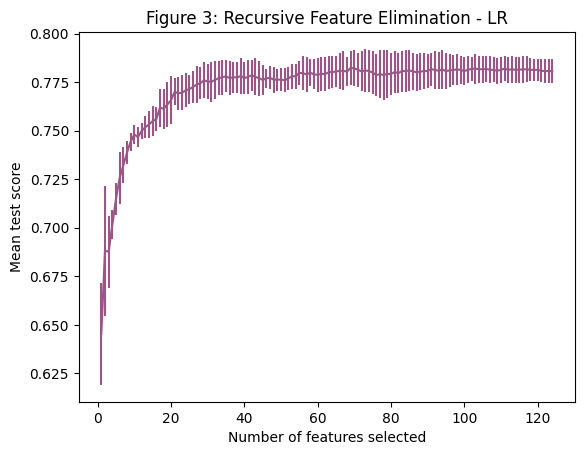

In [68]:
# Calculate the number of different feature selections tested
n_scores_LR = len(rfecv_LR.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores_LR + 1),
    rfecv_LR.cv_results_["mean_test_score"],
    yerr=rfecv_LR.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Figure 3: Recursive Feature Elimination - LR")

# Show the plot
plt.show()

In [87]:
selected_LR_features = X_resampled.columns[rfecv_LR.support_]
eliminated_LR_features = X_resampled.columns[~rfecv_LR.support_]

print("Selected Features for LR:")
print(selected_LR_features)

print("\nEliminated Features for LR:")
print(eliminated_LR_features)

Selected Features for LR:
Index(['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       'one_hot_encoder__apache_3j_bodysystem_Trauma',
       'one_hot_encoder__apache_2_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_2_bodysystem_Haematologic',
       'one_hot_encoder__apache_2_bodysystem_Metabolic',
       'one_hot_encoder__apache_2_bodysystem_Renal/Genitourinary',
       'one_hot_encoder__apache_2_bodysystem_Respiratory',
       'one_hot_encoder__apache_2_bodysystem_Undefined Diagnoses',
       'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
       'one_hot_encoder__gcs_eyes_apache_1',
       'one_hot_encoder__gcs_motor_apache_5',
       'one_hot_encoder__gcs_motor_apache_6',
       'one_hot_encoder__gcs_verbal_apache_

In [72]:
# Accessing the mean test scores
mean_test_scores_LR = rfecv_LR.cv_results_["mean_test_score"]

# Printing the list of mean test scores along with the number of selected features
for i, score_LR in enumerate(mean_test_scores_LR):
    num_selected_features = i + 1  #start with one feature
    print(f"Number of Selected Features: {num_selected_features}, Mean Test Score: {score_LR}")

Number of Selected Features: 1, Mean Test Score: 0.6453812387214406
Number of Selected Features: 2, Mean Test Score: 0.6882143503862028
Number of Selected Features: 3, Mean Test Score: 0.6875770688546291
Number of Selected Features: 4, Mean Test Score: 0.7014839930314893
Number of Selected Features: 5, Mean Test Score: 0.7147593803270704
Number of Selected Features: 6, Mean Test Score: 0.7256650993762059
Number of Selected Features: 7, Mean Test Score: 0.7321425672342631
Number of Selected Features: 8, Mean Test Score: 0.7386236567196798
Number of Selected Features: 9, Mean Test Score: 0.7443117346970634
Number of Selected Features: 10, Mean Test Score: 0.7479467246127044
Number of Selected Features: 11, Mean Test Score: 0.7466825268968272
Number of Selected Features: 12, Mean Test Score: 0.7498413352565423
Number of Selected Features: 13, Mean Test Score: 0.7517378191559111
Number of Selected Features: 14, Mean Test Score: 0.7531592454526722
Number of Selected Features: 15, Mean Test 

While the application of rfecv suggests that the optimal number of variables to inlcude in a logistic regression model is 69, the mean test score does not signifcantly increase after 24 features. Thus, lasso regression will be applied to determine important variables with non-zero coefficients.

**3.2 Applying Lasso Penalty to determine the important features**

In [79]:
#creating a list for features
selected_columns_lasso = ['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       'one_hot_encoder__apache_3j_bodysystem_Trauma',
       'one_hot_encoder__apache_2_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_2_bodysystem_Haematologic',
       'one_hot_encoder__apache_2_bodysystem_Metabolic',
       'one_hot_encoder__apache_2_bodysystem_Renal/Genitourinary',
       'one_hot_encoder__apache_2_bodysystem_Respiratory',
       'one_hot_encoder__apache_2_bodysystem_Undefined Diagnoses',
       'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
       'one_hot_encoder__gcs_eyes_apache_1',
       'one_hot_encoder__gcs_motor_apache_5',
       'one_hot_encoder__gcs_motor_apache_6',
       'one_hot_encoder__gcs_verbal_apache_5', 'remainder__age',
       'remainder__bmi', 'remainder__elective_surgery', 'remainder__height',
       'remainder__weight', 'remainder__apache_3j_diagnosis',
       'remainder__apache_post_operative', 'remainder__gcs_unable_apache',
       'remainder__resprate_apache', 'remainder__ventilated_apache',
       'remainder__d1_diasbp_max', 'remainder__d1_diasbp_min',
       'remainder__d1_diasbp_noninvasive_max',
       'remainder__d1_diasbp_noninvasive_min', 'remainder__d1_heartrate_max',
       'remainder__d1_mbp_min', 'remainder__d1_mbp_noninvasive_max',
       'remainder__d1_mbp_noninvasive_min', 'remainder__d1_resprate_min',
       'remainder__d1_spo2_min', 'remainder__d1_sysbp_noninvasive_max',
       'remainder__d1_sysbp_noninvasive_min', 'remainder__d1_temp_min',
       'remainder__h1_diasbp_min', 'remainder__h1_diasbp_noninvasive_max',
       'remainder__h1_diasbp_noninvasive_min', 'remainder__h1_heartrate_max',
       'remainder__h1_heartrate_min', 'remainder__h1_mbp_min',
       'remainder__h1_mbp_noninvasive_max',
       'remainder__h1_mbp_noninvasive_min', 'remainder__h1_resprate_min',
       'remainder__h1_sysbp_min', 'remainder__h1_sysbp_noninvasive_max',
       'remainder__h1_sysbp_noninvasive_min', 'remainder__d1_bun_max',
       'remainder__d1_bun_min', 'remainder__d1_hco3_max',
       'remainder__d1_hemaglobin_max', 'remainder__d1_hemaglobin_min',
       'remainder__d1_hematocrit_max', 'remainder__d1_hematocrit_min',
       'remainder__d1_platelets_max', 'remainder__d1_platelets_min',
       'remainder__d1_sodium_max', 'remainder__d1_sodium_min',
       'remainder__d1_wbc_max', 'remainder__d1_wbc_min',
       'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob', 'remainder__cirrhosis',
       'remainder__solid_tumor_with_metastasis']

In [96]:
X_lasso = X_resampled[selected_columns_lasso]

In [165]:
from sklearn.preprocessing import StandardScaler

# Scale the features in X_lasso
scaler_lasso = StandardScaler()
X_lasso_scaled = scaler_lasso.fit_transform(X_lasso)

# Create and fit the logistic regression model with Lasso regularization
logistic_regression_lasso = LogisticRegression(penalty='l1', C= 0.0029, solver='liblinear')
logistic_regression_lasso.fit(X_lasso_scaled, y_resampled)


LogisticRegression(C=0.0029, penalty='l1', solver='liblinear')

In [172]:
# Get the coefficients and selected feature names
coefs = logistic_regression_lasso.coef_[0]
selected_features_LR = [feature for feature, coef in zip(selected_columns_lasso, coefs) if abs(coef) != 0]
print(f"Count of variables: {len(selected_features_LR)}")
print("Variable names and their coefficients:")
for feature, coef in zip(selected_features_LR, coefs):
    print(f"{feature}: {coef}")


Count of variables: 24
Variable names and their coefficients:
one_hot_encoder__apache_3j_bodysystem_Metabolic: 0.0
one_hot_encoder__apache_2_bodysystem_Metabolic: 0.0
one_hot_encoder__apache_2_bodysystem_Undefined diagnoses: 0.0
one_hot_encoder__gcs_eyes_apache_1: -0.13735327832373037
one_hot_encoder__gcs_motor_apache_6: 0.0
one_hot_encoder__gcs_verbal_apache_5: 0.0
remainder__age: 0.0
remainder__elective_surgery: 0.0
remainder__apache_post_operative: -0.005462557456136257
remainder__resprate_apache: 0.0
remainder__ventilated_apache: 0.0
remainder__d1_heartrate_max: 0.0
remainder__d1_mbp_min: -0.04204168534903796
remainder__d1_spo2_min: 0.13986136340259667
remainder__d1_sysbp_noninvasive_min: 0.0
remainder__d1_temp_min: -0.07379106681832831
remainder__h1_mbp_noninvasive_min: -0.14017359065910004
remainder__h1_resprate_min: 0.1716395276591899
remainder__d1_bun_max: 0.0
remainder__d1_bun_min: -0.16740264915035158
remainder__d1_hco3_max: 0.0
remainder__d1_wbc_max: 0.0
remainder__apache_4a

In [174]:
selected_features_LR

['one_hot_encoder__apache_3j_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
 'one_hot_encoder__gcs_eyes_apache_1',
 'one_hot_encoder__gcs_motor_apache_6',
 'one_hot_encoder__gcs_verbal_apache_5',
 'remainder__age',
 'remainder__elective_surgery',
 'remainder__apache_post_operative',
 'remainder__resprate_apache',
 'remainder__ventilated_apache',
 'remainder__d1_heartrate_max',
 'remainder__d1_mbp_min',
 'remainder__d1_spo2_min',
 'remainder__d1_sysbp_noninvasive_min',
 'remainder__d1_temp_min',
 'remainder__h1_mbp_noninvasive_min',
 'remainder__h1_resprate_min',
 'remainder__d1_bun_max',
 'remainder__d1_bun_min',
 'remainder__d1_hco3_max',
 'remainder__d1_wbc_max',
 'remainder__apache_4a_hospital_death_prob',
 'remainder__solid_tumor_with_metastasis']

**3.3 Developing a logistic regression prediction model**

In [175]:
LR_features = ['one_hot_encoder__apache_3j_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
 'one_hot_encoder__gcs_eyes_apache_1',
 'one_hot_encoder__gcs_motor_apache_6',
 'one_hot_encoder__gcs_verbal_apache_5',
 'remainder__age',
 'remainder__elective_surgery',
 'remainder__apache_post_operative',
 'remainder__resprate_apache',
 'remainder__ventilated_apache',
 'remainder__d1_heartrate_max',
 'remainder__d1_mbp_min',
 'remainder__d1_spo2_min',
 'remainder__d1_sysbp_noninvasive_min',
 'remainder__d1_temp_min',
 'remainder__h1_mbp_noninvasive_min',
 'remainder__h1_resprate_min',
 'remainder__d1_bun_max',
 'remainder__d1_bun_min',
 'remainder__d1_hco3_max',
 'remainder__d1_wbc_max',
 'remainder__apache_4a_hospital_death_prob',
 'remainder__solid_tumor_with_metastasis']

In [179]:
#Fitting the data
X_train_scaled_LR = scaler.fit_transform(X_resampled[LR_features])
X_test_scaled_LR = scaler.transform(X_test[LR_features])

In [180]:
LR_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
LR_model.fit(X_train_scaled_LR, y_resampled)

LogisticRegression(solver='liblinear')

In [182]:
# Using cross_val_predict to get predicted labels for each fold of cross-validation
predicted_labels_LR_model = cross_val_predict(LR_model, X_train_scaled_LR, y_resampled, cv=5)

# Calculating the full confusion matrix
conf_matrix_LR = confusion_matrix(y_resampled, predicted_labels_LR_model)

# Calculate the full classification report
class_report_LR = classification_report(y_resampled, predicted_labels_LR_model)

# Calculate accuracy
accuracy_LR = accuracy_score(y_resampled, predicted_labels_LR_model)

# Calculate precision
precision_LR = precision_score(y_resampled, predicted_labels_LR_model)

# Calculate recall
recall_LR = recall_score(y_resampled, predicted_labels_LR_model)

# Calculate F1 score
f1_LR = f1_score(y_resampled, predicted_labels_LR_model)


# Print the full confusion matrix and classification report
print("Table 1A: Filtered Logistic Model Confusion Matrix/Classification Report")
print("A. Confusion Matrix:")
print(conf_matrix_LR)
print("B. Classification Report:")
print(class_report_LR)
print("C. Accuracy: {:.2f}".format(accuracy_LR))
print("D. Precision: {:.2f}".format(precision_LR))
print("E. Recall (Sensitivity): {:.2f}".format(recall_LR))
print("F. F1 Score: {:.2f}".format(f1_LR))

Table 1A: Filtered Logistic Model Confusion Matrix/Classification Report
A. Confusion Matrix:
[[5032 1296]
 [1429 4899]]
B. Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      6328
           1       0.79      0.77      0.78      6328

    accuracy                           0.78     12656
   macro avg       0.78      0.78      0.78     12656
weighted avg       0.78      0.78      0.78     12656

C. Accuracy: 0.78
D. Precision: 0.79
E. Recall (Sensitivity): 0.77
F. F1 Score: 0.78


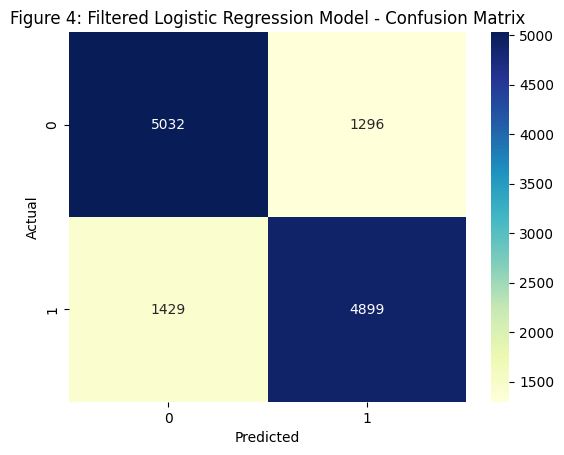

In [183]:
sns.heatmap(conf_matrix_LR, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Figure 4: Filtered Logistic Regression Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

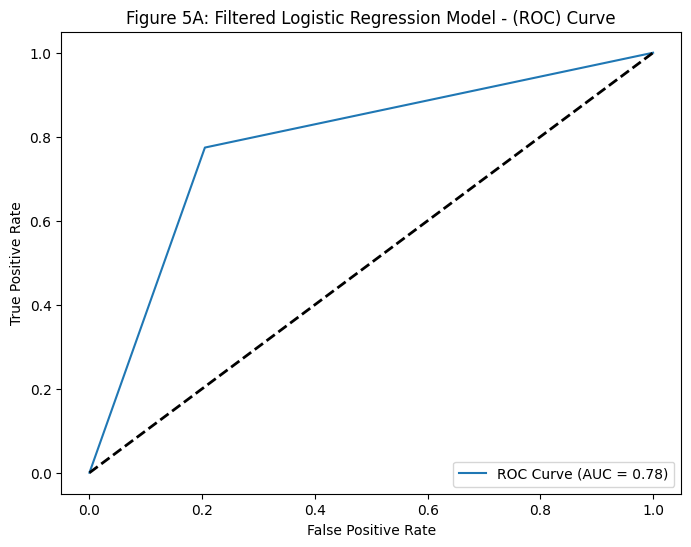

In [184]:
predicted_probs_LR = cross_val_predict(LR_model, X_train_scaled_LR, y_resampled, cv=5)

# Calculate ROC-AUC
roc_auc_LR = roc_auc_score(y_resampled, predicted_probs_LR)

# Calculate ROC curve
fpr_LR, tpr_LR, _ = roc_curve(y_resampled, predicted_probs_LR)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_LR, tpr_LR, label=f'ROC Curve (AUC = {roc_auc_LR:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 5A: Filtered Logistic Regression Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [185]:
# Making predictions on the test set of Logit Regression
y_pred_test_LR = LR_model.predict(X_test_scaled_LR)

# Calculating metrics
accuracy_test_LR = accuracy_score(y_test, y_pred_test_LR)
precision_test_LR = precision_score(y_test, y_pred_test_LR)
recall_test_LR = recall_score(y_test, y_pred_test_LR)
f1_test_LR = f1_score(y_test, y_pred_test_LR)
conf_matrix_test_LR = confusion_matrix(y_test, y_pred_test_LR)

# Printing the evaluation metrics
print("Table 1B: Filtered Logistic Model - Test Set- Confusion Matrix/Classification Report")
print("Accuracy: {:.2f}".format(accuracy_test_LR))
print("Precision: {:.2f}".format(precision_test_LR))
print("Recall (Sensitivity): {:.2f}".format(recall_test_LR))
print("F1 Score: {:.2f}".format(f1_test_LR))
print("Confusion Matrix:")
print(conf_matrix_test_LR)

Table 1B: Filtered Logistic Model - Test Set- Confusion Matrix/Classification Report
Accuracy: 0.79
Precision: 0.26
Recall (Sensitivity): 0.77
F1 Score: 0.39
Confusion Matrix:
[[13322  3434]
 [  360  1227]]


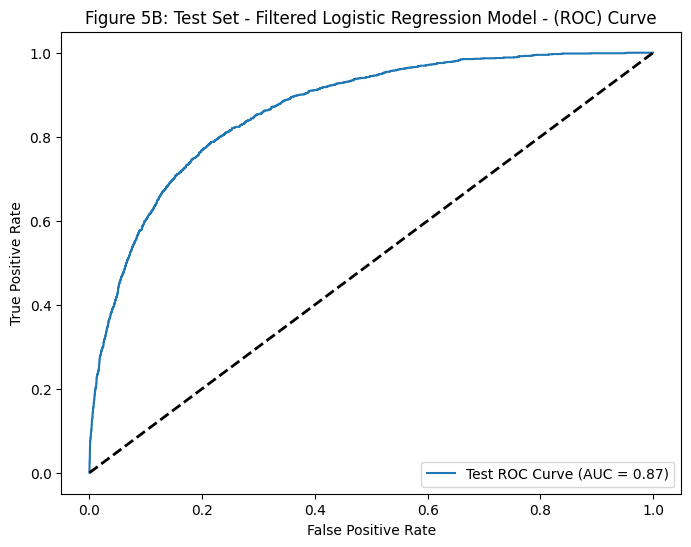

In [186]:
# Making predictions on the test set of Logistic Regression
predicted_probs_test_LR = LR_model.predict_proba(X_test_scaled_LR)[:, 1]

# Calculate ROC-AUC on the test set
roc_auc_test_LR = roc_auc_score(y_test, predicted_probs_test_LR)

# Calculate ROC curve on the test set
fpr_test_LR, tpr_test_LR, _ = roc_curve(y_test, predicted_probs_test_LR)

# Plot ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_LR, tpr_test_LR, label=f'Test ROC Curve (AUC = {roc_auc_test_LR:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 5B: Test Set - Filtered Logistic Regression Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

It seems the logistic regression is performing relatively well. Accuracy and recall scores on unseen (test) data is 0.79 and 0.77 respectively. AUC of the application of the model on the unseen is 0.87 which is an increase of 10 points, compared to the AUC of the application of the model on the training data. Yet, due the complex relationship between dependent variables, decisionTrees may provide better perdictive abilities